In [1]:
# imports
import numpy as np

# modelling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

# Tree Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os

In [2]:
# function to load and preprocess quickdraw data
def load_quickdraw_data(dir, category_name, n_samples=1000):
    file = f'full_numpy_bitmap_{category_name}.npy'
    data = np.load(dir + file)
    if n_samples == -1:
        return data
    else:
        indices = np.random.choice(len(data), n_samples, replace=False)
        sampled_data = data[indices]
        return sampled_data

In [3]:
def data_generator(data, batch_size=512):
    n_samples = len(data)
    for i in range(0, n_samples, batch_size):
        batch = data[i:i + batch_size]
        yield batch

In [4]:
files = os.listdir('../data/')
categories = [file.split('_')[-1].split('.')[0] for file in files]

In [5]:
# Data directory
dir = '../data/'

# Load and preprocess data
all_data = []
labels = []

In [6]:
for category_name in categories:
    category_data = load_quickdraw_data(dir, category_name, 100) # Change this to -1 for all data
    all_data.extend(category_data)
    labels.extend([category_name] * len(category_data))

In [7]:
# split the data into training and test
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)

print(len(all_data))

34500


In [8]:
# normalize data
x_train = np.array(x_train).astype(np.float32) / 255
x_test = np.array(x_test).astype(np.float32) / 255

In [9]:
# Add Outliers
num_outliers = 500

# Generate random outliers
outliers = np.random.rand(num_outliers, 784)

In [10]:
# Append outliers to your training data
x_train_with_outliers = np.vstack((x_train, outliers))

# Create labels for the outliers (e.g., label them as "outlier" or use a different category)
y_train_with_outliers = y_train + ['outlier'] * num_outliers

In [11]:
# Perform PCA for dimensionality reduction
n_components = 20  # You can choose the number of components

pca = PCA(n_components=n_components, svd_solver='full')

In [12]:
x_train_pca = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_train_with_outliers):
    batch_pca = pca.fit_transform(batch)
    if x_train_pca is None:
        x_train_pca = batch_pca
    else:
        x_train_pca = np.vstack((x_train_pca, batch_pca))

In [13]:
x_test_pca = None
# Perform PCA on x_train_with_outliers using a generator
for batch in data_generator(x_test):
    batch_pca = pca.transform(batch)
    if x_test_pca is None:
        x_test_pca = batch_pca
    else:
        x_test_pca = np.vstack((x_test_pca, batch_pca))

In [14]:
# Train the LOF model using data generator with PCA
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)  # Adjust parameters as needed

for batch in data_generator(x_train_with_outliers):
    # Perform PCA for dimensionality reduction on each batch
    x_batch_pca = pca.fit_transform(batch)
    
    # Train the LOF model on the PCA-transformed batch
    lof.fit(x_batch_pca)

In [15]:
# Predict anomalies using data generator with PCA
y_pred = []
for batch in data_generator(x_test):
    # Perform PCA for dimensionality reduction on each batch
    x_test_pca = pca.transform(batch)
    
    # Predict anomalies for the PCA-transformed batch
    batch_pred = lof.fit_predict(x_test_pca)
    y_pred.extend(batch_pred)

In [16]:
# Adjust the prediction labels for anomalies
y_pred_adjusted = [-1 if pred == -1 else 1 for pred in y_pred]

y_true = [1 if label == 'outlier' else -1 for label in y_test]

In [17]:
# Evaluate the model
print("Precision:", precision_score(y_true, y_pred_adjusted))
print("Recall:", recall_score(y_true, y_pred_adjusted))
print("F1-Score:", f1_score(y_true, y_pred_adjusted))
print("Classification Report:\n", classification_report(y_true, y_pred_adjusted))

Precision: 0.0
Recall: 0.0
F1-Score: 0.0
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.10      0.18      6900
           1       0.00      0.00      0.00         0

    accuracy                           0.10      6900
   macro avg       0.50      0.05      0.09      6900
weighted avg       1.00      0.10      0.18      6900



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: Undefine

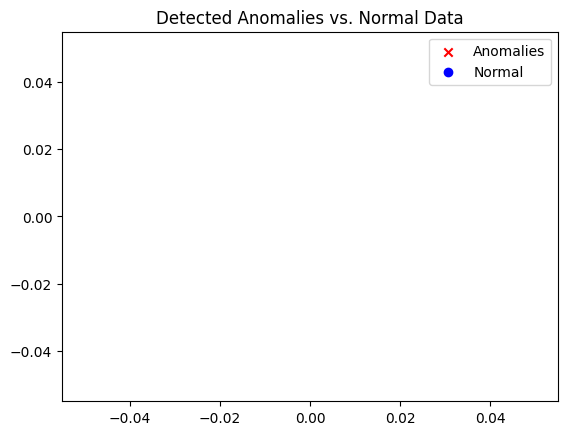

In [18]:
# Visualize detected anomalies separately
anomalies = np.array(x_test)[y_pred == -1]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='x', label='Anomalies')
plt.scatter(np.array(x_test)[y_pred == 1][:, 0], np.array(x_test)[y_pred == 1][:, 1], c='blue', marker='o', label='Normal')
plt.legend()
plt.title("Detected Anomalies vs. Normal Data")
plt.show()

In [19]:
# Feature importance analysis (explained variance ratio)
explained_variance = pca.explained_variance_ratio_
print("Explained Variance of Principal Components:")
print(explained_variance)

Explained Variance of Principal Components:
[0.00675824 0.00666305 0.00661486 0.00649966 0.0064509  0.00634135
 0.00630038 0.00624414 0.00617312 0.00615032 0.00604803 0.00600065
 0.00598263 0.00592196 0.0058636  0.00583936 0.0058333  0.00576632
 0.00570171 0.00567199]


In [20]:
# Calculate performance metrics for anomalies
anomalies_precision = precision_score(y_true, y_pred_adjusted)
anomalies_recall = recall_score(y_true, y_pred_adjusted)
anomalies_f1_score = f1_score(y_true, y_pred_adjusted)
print("Anomalies Precision:", anomalies_precision)
print("Anomalies Recall:", anomalies_recall)
print("Anomalies F1-Score:", anomalies_f1_score)

Anomalies Precision: 0.0
Anomalies Recall: 0.0
Anomalies F1-Score: 0.0


c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
